In [1]:
from tqdm import tqdm
from typing import Optional, List
import numpy as np

def _get_binned_entropy(x: np.array, num_bins: Optional[int]=100, 
                        bin_edges: Optional[np.array]=None) -> float:
    """
    Compute entropy by discretizing the given continuous random variables.
    Discretization here is done by binning the continuous values into 
    equally-spaced descrete clusters. 

    Parameters
    ----------
    x           :   (n_samples, d) the continuous random variable
                    where, d \in {1, 2}. 
    num_bins    :   number of bins into which to cluster the values.
                    if, d==2: we would use num_bins**2 bins.
    bin_edges   :   pre-computed bin edges for discretization of reps;
                    this is usually used when global binning is employed.
    
    Returns
    -------
    h           :   entropy H(X)

    """
    if x.shape[1] == 2:
        x_1, x_2 = x[:, 0], x[:, 1]
        if bin_edges is None:
            _, bin_edges = np.histogram2d(x_1, x_2, bins=num_bins)
        bin_edges_1, bin_edges_2 = bin_edges
        binned_x_1, binned_x_2 = np.digitize(x_1, bin_edges_1), np.digitize(x_1, bin_edges_2)
        clusters, num_c = {}, 0
        for i in np.unique(binned_x_1):
            for j in np.unique(binned_x_2):
                if((i, j) not in clusters):
                    clusters[(i, j)] = num_c
                    num_c += 1
        binned_x = np.array([clusters[(binned_x_1[i], binned_x_2[i])] for i in range(len(x))])
    else:
        x = x.reshape(-1)
        if bin_edges is None:
            _, bin_edges = np.histogram(x, bins=num_bins)
        binned_x = np.digitize(x, bin_edges)

    def _get_discrete_entropy(X: np.array) -> float:
        _, counts = np.unique(X, return_counts=True)
        probs = counts / len(X)
        if np.count_nonzero(probs) <= 1:
            return 0

        ent = 0.
        for i in probs:
            ent -= i * np.log(i)

        return ent

    return _get_discrete_entropy(binned_x)

def get_all_entropies(reps: np.array,
                      num_neighbors: Optional[int] = 100, 
                      global_binning: Optional[bool] = True,
                      bin_edges: Optional[list] = List) -> np.array:
    """
    Get num_neurons (N) sized vector, each value representing the 
    **unnormalized** entropy for that neuron.

    Parameters
    ----------
    reps            :   (n_samples, n_neurons) flattened model activations.
    num_neighbors   :   number of neighbors to consider for KNN-based entropy computation,
                        when using binning to compute entropy, this is used as ```num_bins```.
    global_binning  :   whether to employ global binning for binning-based computation or not.

    Returns
    -------
    entropies       :   (n_neurons, n_neurons) unnormalized MI values between each 
                        pairwise neuron pair from the given set.
    """
    num_vars = reps.shape[-1]
    entropies = np.zeros(num_vars)
    # if global_binning:
    #     _, bin_edges = np.histogram(reps.reshape(-1), bins=num_neighbors)

    for i in tqdm(range(num_vars)):
        h = _get_binned_entropy(reps[:, i].reshape(-1, 1),
                                        num_bins=num_neighbors,
                                        bin_edges=bin_edges)
        entropies[i] = h    

    return entropies

In [2]:
import gzip
import pickle

def data_getter(path):
    with gzip.open(path, 'rb') as f:
         data = pickle.load(f)
    return np.array(data)

data_L = data_getter('data/s1-L/ent/selection_35_fa.pkl.gz')
# data_M = data_getter('data/s2-M/ent/selection_15.pkl.gz')
data_ML = data_getter('data/s3-ML/ent/selection_22_fa.pkl.gz')
data_HL = data_getter('data/s4-HL/ent/selection_43_fa.pkl.gz')
data_HM = data_getter('data/s5-HM/ent/selection_6_fa.pkl.gz')
data_HH = data_getter('data/s6-HH/ent/selection_40_fa.pkl.gz')

In [4]:
def get_edges(data_list):
    data = np.concatenate(data_list, axis=0)
    _, bin_edges = np.histogram(data.reshape(-1), bins=1000)
    return bin_edges

bin_edges = get_edges([data_L, data_ML, data_HL, data_HM, data_HH])

In [6]:
def get_final_arrow_fa(data, bin_edges):
    last_arr = data.transpose(1,0,2)
    c_reps = np.concatenate([last_arr[i, :, :] for i in range(last_arr.shape[0])], axis=1)
    entropies = get_all_entropies(c_reps, num_neighbors=1000, bin_edges = bin_edges)
    return entropies.reshape(48,1600)
 
entropies_L = get_final_arrow_fa(data_L, bin_edges)
# entropies_M = get_final_arrow_fa(data_M, bin_edges)
entropies_ML = get_final_arrow_fa(data_ML, bin_edges)
entropies_HL = get_final_arrow_fa(data_HL, bin_edges)
entropies_HM = get_final_arrow_fa(data_HM, bin_edges)
entropies_HH = get_final_arrow_fa(data_HH, bin_edges)

# # data shape of 550,48,numtoken,1600
# def get_final_arrow(data, bin_edges):
#     last_arr = data[:,:,-1,:].transpose(1,0,2)
#     c_reps = np.concatenate([last_arr[i, :, :] for i in range(last_arr.shape[0])], axis=1)
#     entropies = get_all_entropies(c_reps, num_neighbors=1000, bin_edges = bin_edges)
#     return entropies.reshape(48,1600)

# entropies_HM = get_final_arrow(data_HM, bin_edges)
# entropies_HH = get_final_arrow(data_HH, bin_edges)


100%|██████████| 76800/76800 [00:04<00:00, 16841.90it/s]


In [8]:
del data_HH, data_HM
import gc
gc.collect()

3

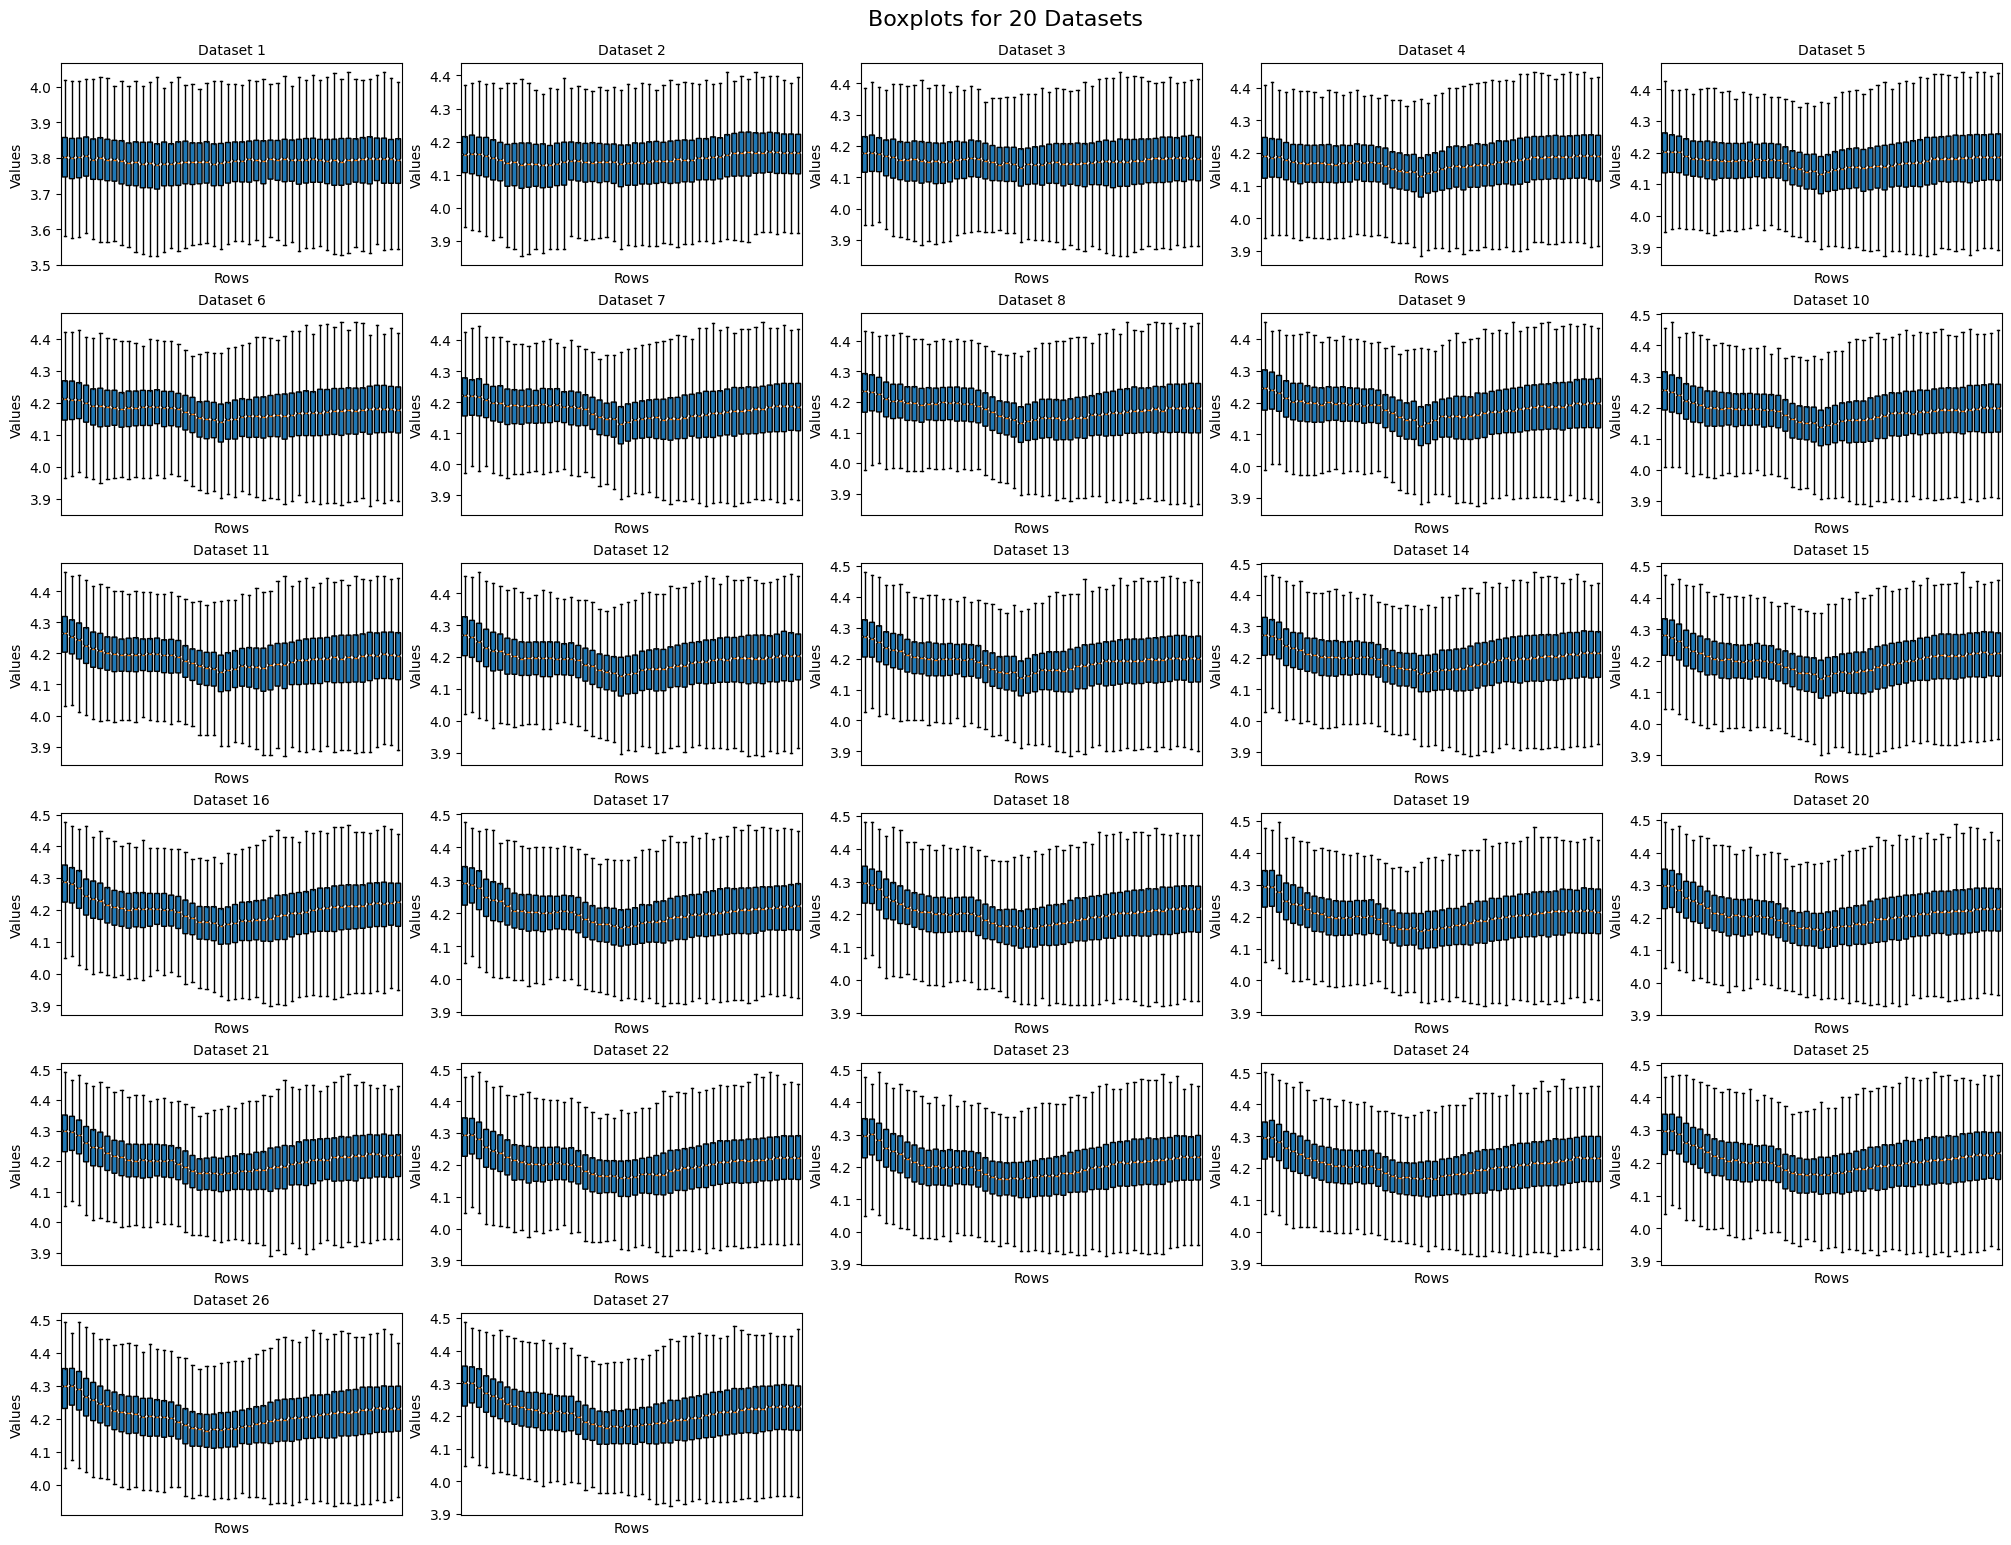

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Create a list of 20 datasets with size (48, 1600)
data_list = entropies_HM_all

# Grid configuration (e.g., 4 rows x 5 columns)
rows, cols = 6, 5

# Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), constrained_layout=True)

# Plot each dataset in its respective subplot
for i, data in enumerate(data_list):
    ax = axes[i // cols, i % cols]  # Access the correct subplot
    ax.boxplot(data.T, notch=True, patch_artist=True, showfliers=False, widths=0.7)
    ax.set_title(f'Dataset {i + 1}', fontsize=10)
    ax.set_xticks([])  # Remove x-tick labels to avoid clutter
    ax.set_xlabel('Rows')
    ax.set_ylabel('Values')

# Remove unused subplots if the number of datasets is less than rows * cols
if len(data_list) < rows * cols:
    for j in range(len(data_list), rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

# Show the plot
plt.suptitle('Boxplots for 20 Datasets', fontsize=16, y=1.02)
plt.show()


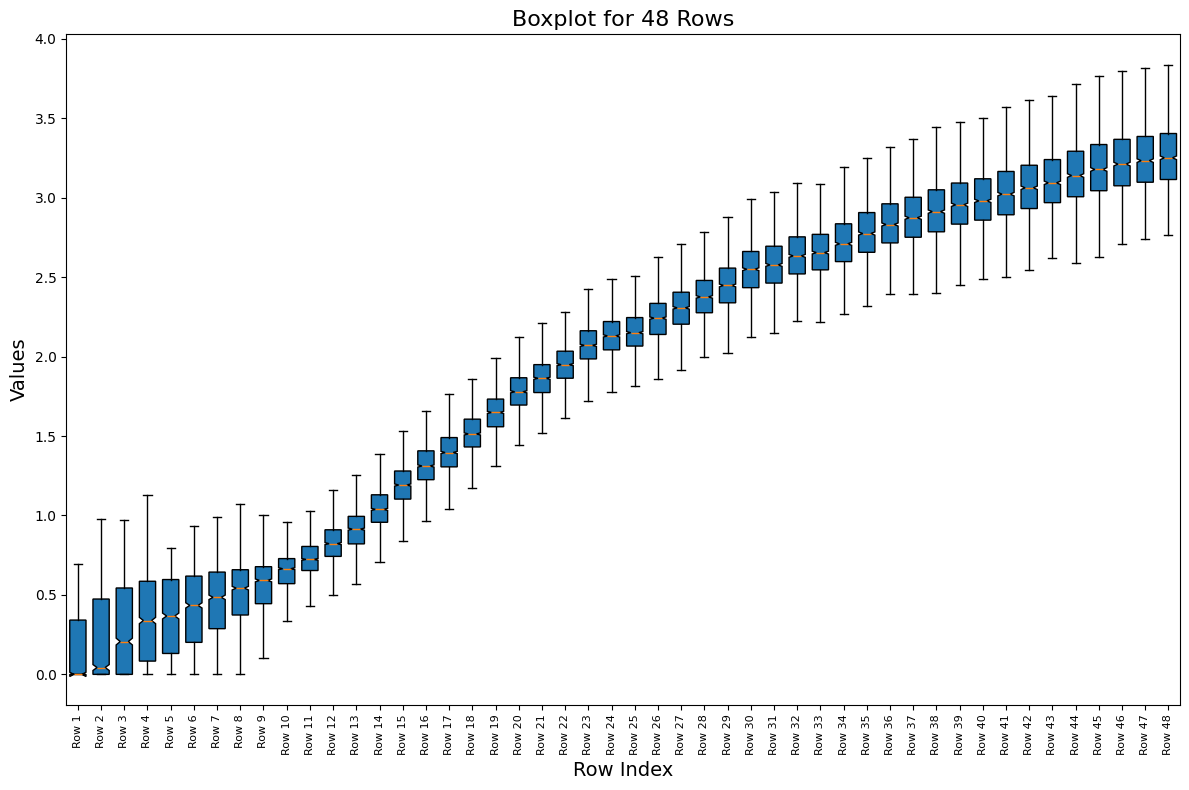

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Example 2D array (48 rows, 1600 columns)
data = entropies_HM

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size for better visibility
ax.boxplot(data.T, notch=True, patch_artist=True, showfliers=False, widths=0.7)

# Customize plot
ax.set_title('Boxplot for 48 Rows', fontsize=16)
ax.set_xlabel('Row Index', fontsize=14)
ax.set_ylabel('Values', fontsize=14)
ax.set_xticks(range(1, 49))  # x-ticks for all 48 rows
ax.set_xticklabels([f'Row {i}' for i in range(1, 49)], rotation=90, fontsize=8)  # Rotate labels

plt.tight_layout()  # Adjust layout to fit
plt.show()


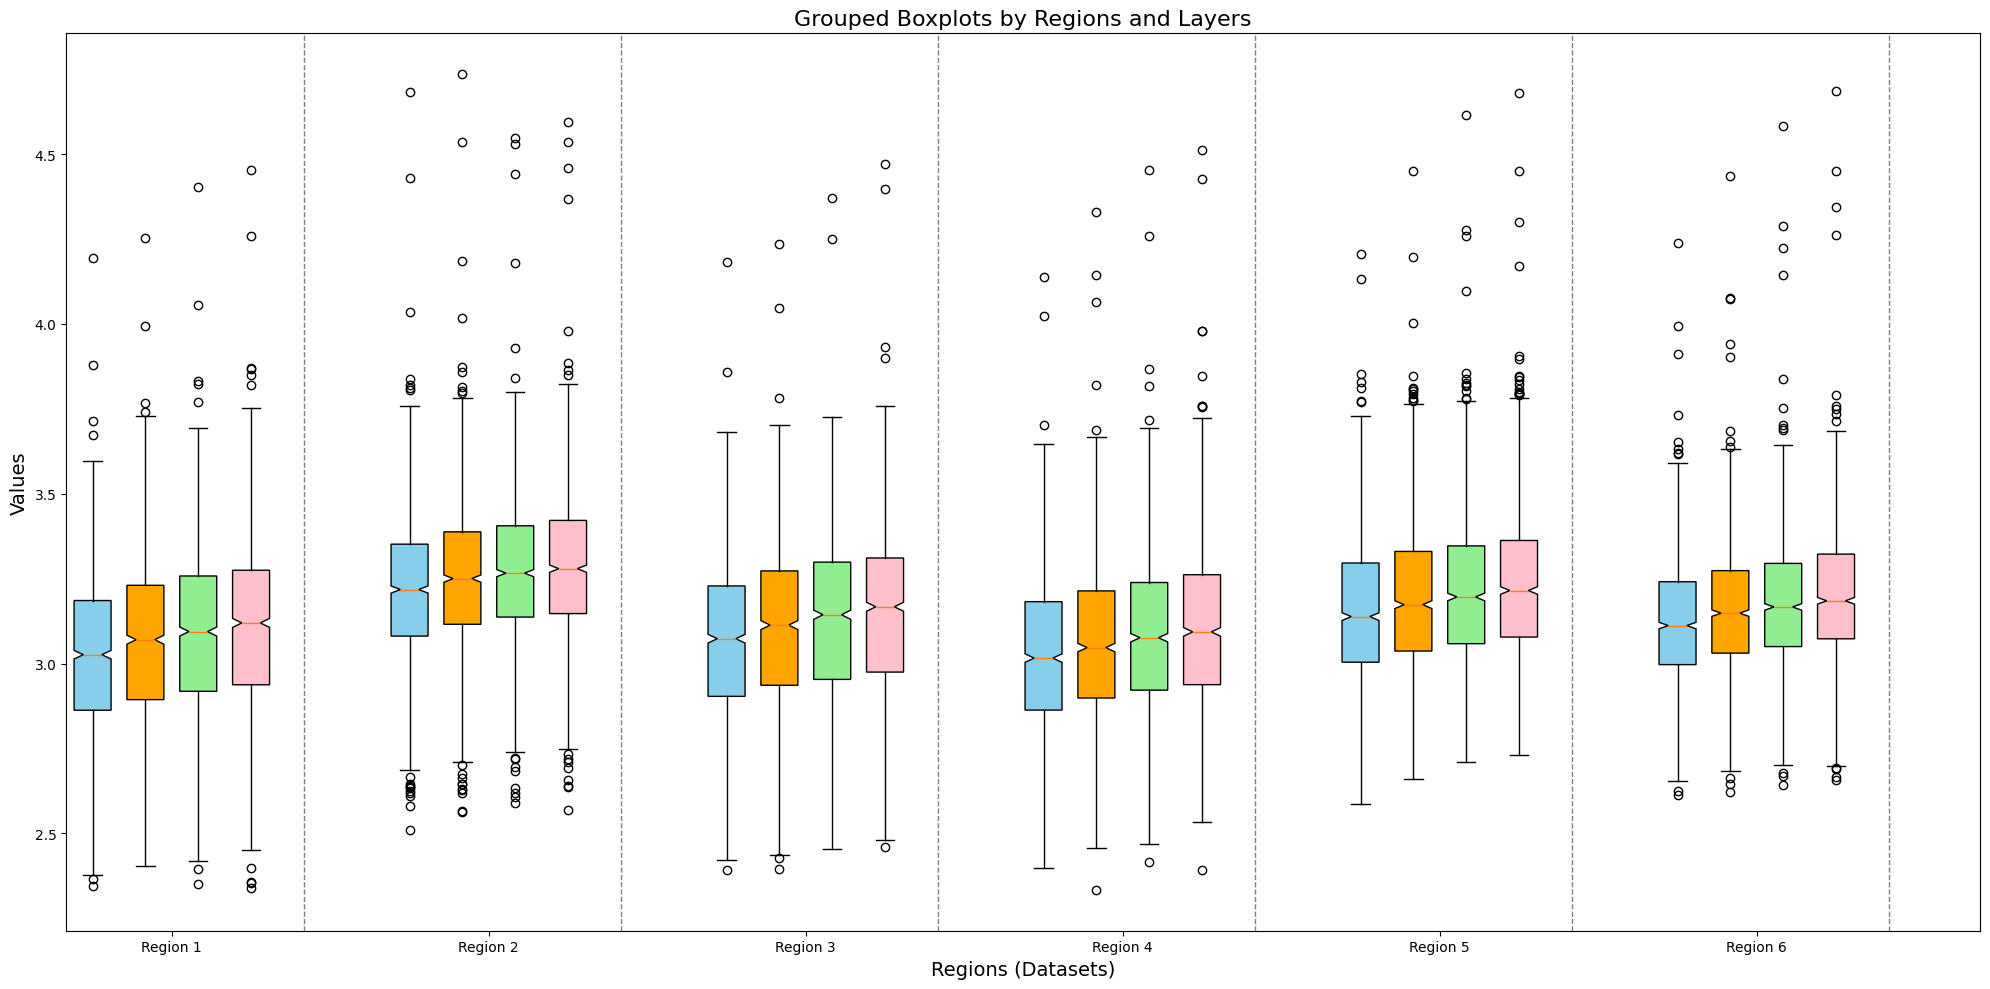

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Example: List of `n` NumPy arrays (each with shape 4x1600)
n = 6  # Number of datasets
data_list = [entropies_L[-4:], entropies_M[-4:], entropies_ML[-4:], entropies_HL[-4:], entropies_HM[-4:], entropies_HH[-4:]]  # Example data

# Prepare data for boxplots
boxplot_data = []
group_positions = []
gap = 2  # Gap between regions
current_position = 1  # Starting position for boxplots
colors = ['skyblue', 'orange', 'lightgreen', 'pink', 'green', 'olive']  # Colors for the layers

# Organize data by regions (each region corresponds to one dataset)
for dataset_idx, data in enumerate(data_list):
    for layer_idx in range(4):  # Iterate over 4 layers
        boxplot_data.append(data[layer_idx])  # Add data for this layer
        group_positions.append(current_position)
        current_position += 1
    current_position += gap  # Add gap after each region

# Create the boxplot
fig, ax = plt.subplots(figsize=(20, 10))
box = ax.boxplot(boxplot_data, positions=group_positions, notch=True, patch_artist=True, widths=0.7)

# Customize box colors by layers
for i, patch in enumerate(box['boxes']):
    layer_idx = i % 4  # Determine the layer index for the box
    patch.set_facecolor(colors[layer_idx])

# Add vertical dashed lines to separate regions
for pos in group_positions[3::4]:  # Dashed line after every 4 boxplots (end of each region)
    ax.axvline(pos + gap / 2, color='gray', linestyle='--', linewidth=1)

# Customize x-axis
region_positions = [np.mean(group_positions[i * 4:(i + 1) * 4]) for i in range(n)]
ax.set_xticks(region_positions)
ax.set_xticklabels([f'Region {i + 1}' for i in range(n)], fontsize=10)

# Add labels and title
ax.set_title('Grouped Boxplots by Regions and Layers', fontsize=16)
ax.set_ylabel('Values', fontsize=14)
ax.set_xlabel('Regions (Datasets)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
[entropies_HL[-4:], entropies_HM[-4:], entropies_HH[-4:]]

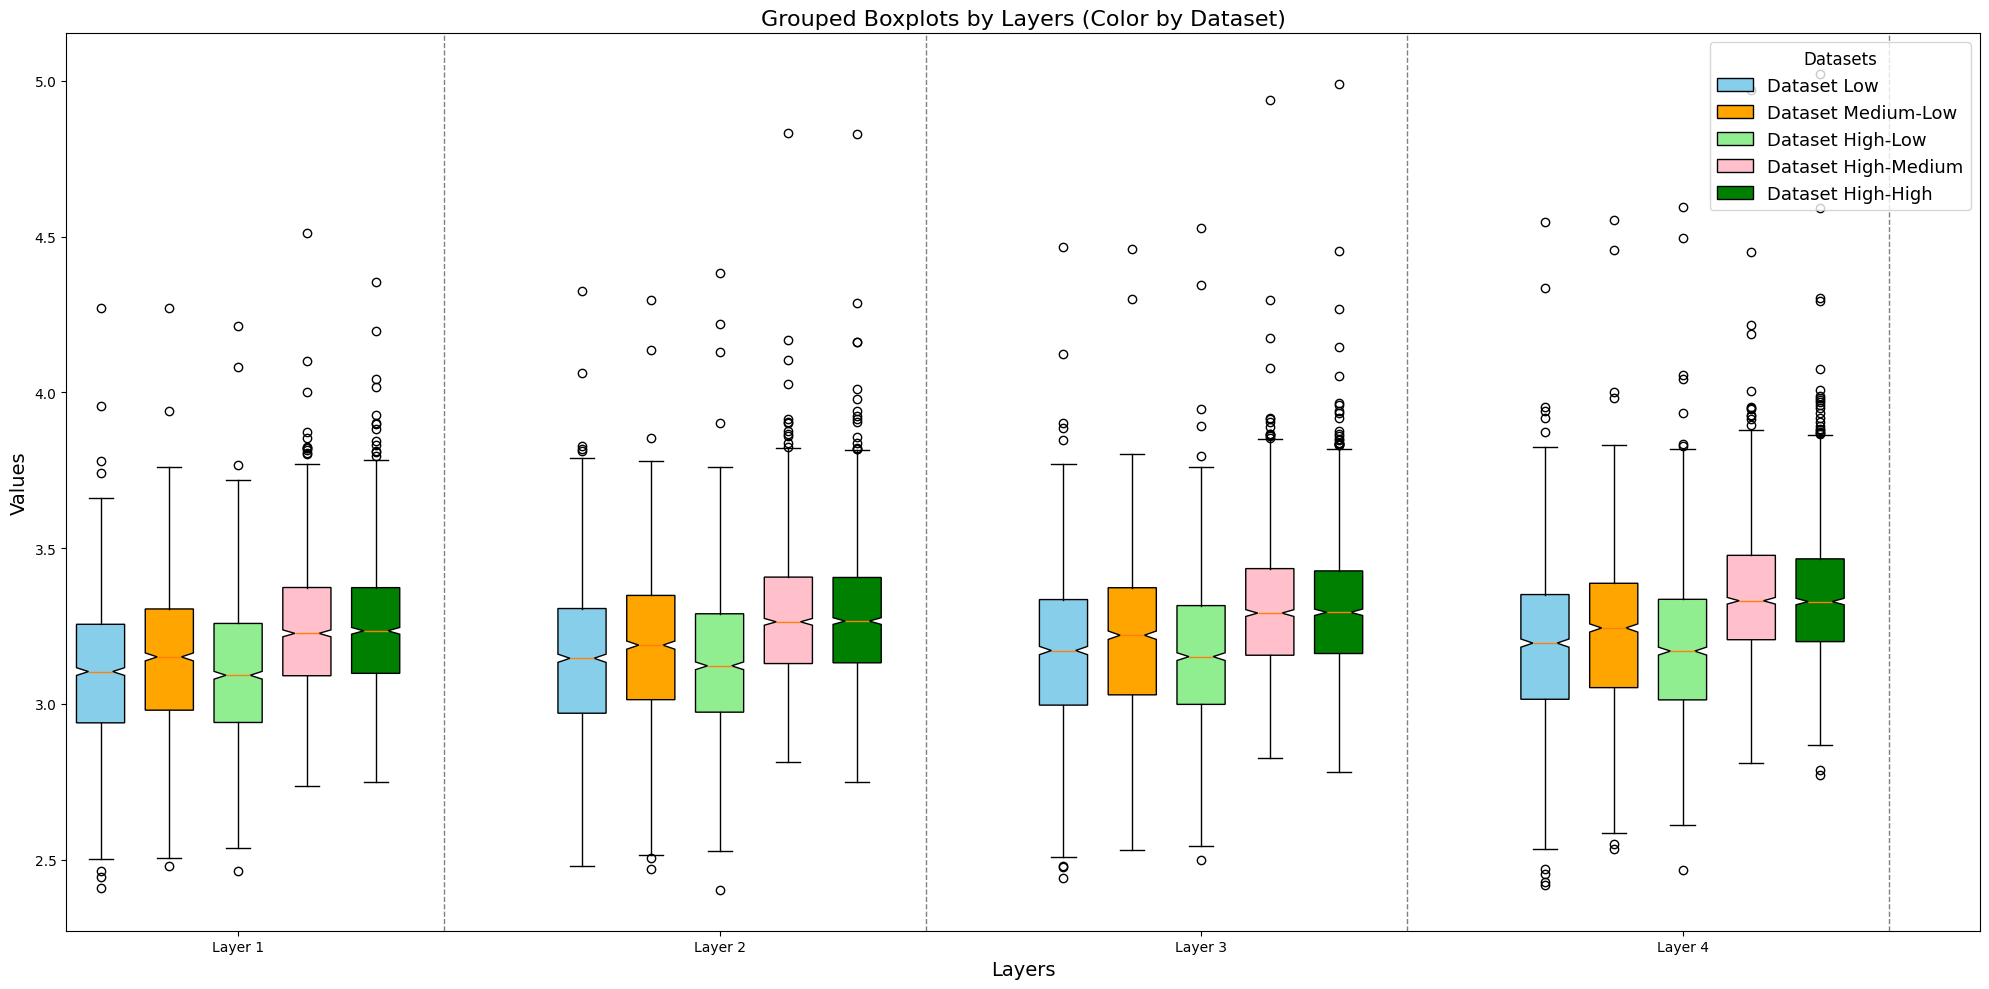

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Example: List of `n` NumPy arrays (each with shape 4x1600)
n = 5  # Number of datasets
dataset_names = ['Low', 'Medium-Low', 'High-Low', 'High-Medium', 'High-High']
data_list = [entropies_L[-4:], entropies_ML[-4:], entropies_HL[-4:], entropies_HM[-4:], entropies_HH[-4:]]  # Example data

# Prepare data for boxplots
boxplot_data = []
group_positions = []
gap = 2  # Gap between regions
current_position = 1  # Starting position for boxplots
colors = ['skyblue', 'orange', 'lightgreen', 'pink', 'green', 'olive']  # Colors for the datasets

# Organize data by layers (Layer 1, Layer 2, etc.)
for layer_idx in range(4):  # Iterate over 4 layers
    for dataset_idx, data in enumerate(data_list):  # Iterate over datasets
        boxplot_data.append(data[layer_idx])  # Add data for this layer
        group_positions.append(current_position)
        current_position += 1
    current_position += gap  # Add gap after each layer

# Create the boxplot
fig, ax = plt.subplots(figsize=(20, 10))
box = ax.boxplot(boxplot_data, positions=group_positions, notch=True, patch_artist=True, widths=0.7)

# Correctly customize box colors by datasets
for i, patch in enumerate(box['boxes']):
    dataset_idx = i % n  # Determine the dataset index for the box
    patch.set_facecolor(colors[dataset_idx])

# Add vertical dashed lines to separate layers
for pos in group_positions[n - 1::n]:  # Dashed line after every n boxplots (end of each layer group)
    ax.axvline(pos + gap / 2, color='gray', linestyle='--', linewidth=1)

# Customize x-axis labels
layer_positions = [np.mean(group_positions[i * n:(i + 1) * n]) for i in range(4)]  # Correctly calculate positions
ax.set_xticks(layer_positions)  # Add ticks at calculated positions
ax.set_xticklabels([f'Layer {i + 1}' for i in range(4)], fontsize=10)  # Ensure all 4 labels appear

# Add labels and title
ax.set_title('Grouped Boxplots by Layers (Color by Dataset)', fontsize=16)
ax.set_ylabel('Values', fontsize=14)
ax.set_xlabel('Layers', fontsize=14)

# Create legend for datasets
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'Dataset {n}') for i,n in enumerate(dataset_names)]
ax.legend(handles=legend_elements, title='Datasets', loc='upper right', fontsize=13, title_fontsize=12)


# Show the plot
plt.tight_layout()
plt.show()


# Mutual Information

In [1]:
# import numpy as np
# from typing import Optional, List
# from tqdm import tqdm
# import multiprocessing
# from joblib import Parallel, delayed
# import bmi

# from sklearn.neighbors import NearestNeighbors, KDTree
# from scipy.special import gamma, digamma

# NUM_CORES = multiprocessing.cpu_count()

# def _get_knn_mi(x: np.array, y: np.array, n_neighbors: int, clip_negative: Optional[bool] = True) -> float:
#     """
#     Compute mutual information between two continuous variables.
#     Parameters
#     ----------
#     x, y            :   (n_samples,) Samples of two continuous random variables, 
#                         must have an identical shape.
#     n_neighbors     :   Number of nearest neighbors to search for each point, see [1].
#     clip_negative   :   Whether to clip negative values to zero.
    
#     Returns
#     -------
#     mi          :   Estimated mutual information. 
#                     If it turned out to be negative it is replace by 0.
    
#     NOTE
#     -----
#     True mutual information can't be negative. If its estimate by a numerical
#     method is negative, it means (providing the method is adequate) that the
#     mutual information is close to 0 and replacing it by 0 is a reasonable
#     strategy.
    
#     References
#     ----------
#     .. [1] A. Kraskov, H. Stogbauer and P. Grassberger, "Estimating mutual
#            information". Phys. Rev. E 69, 2004.
#     """
#     n_samples = x.size

#     x = x.reshape((-1, 1))      # (n_samples, 1)
#     y = y.reshape((-1, 1))      # (n_samples, 1)
#     xy = np.hstack((x, y))      # z = (x, y) -> (n_samples, 2)

#     # Here we rely on NearestNeighbors to select the fastest algorithm.
#     nn = NearestNeighbors(metric="chebyshev", n_neighbors=n_neighbors)
#     # ^ distance metric used is the max-norm (https://en.wikipedia.org/wiki/Chebyshev_distance)
#     # dist(z2, z1) = max(||x2-x1||, ||y2-y1||)
#     # the same metric is used for x and y, i.e., simply
#     # dist(x2, x1) = (x2 - x1), when x is 1-dimensional
    
#     nn.fit(xy)                              # fitting KNN on joint z = (x, y)
#     radius = nn.kneighbors()[0]             # kneighbors() returns (distances, neighbors) 
#                                             # for all samples -> (2, n_samples, n_neighbors)
#                                             # we only use the distances as the query radii 
#     radius = np.nextafter(radius[:, -1], 0)

#     # KDTree is explicitly fit to allow for the querying of number of
#     # neighbors within a specified radius
#     kd = KDTree(x, metric="chebyshev")
#     nx = kd.query_radius(x, radius, 
#                          count_only=True, 
#                          return_distance=False) # number of points in x that are within the query radius
#                                                 # -> (n_samples)
#     nx = np.array(nx) - 1.0                     # (nx-1)

#     kd = KDTree(y, metric="chebyshev")
#     ny = kd.query_radius(y, radius, 
#                          count_only=True, 
#                          return_distance=False) # number of points in y that are within the query radius
#                                                 # -> (n_samples)
#     ny = np.array(ny) - 1.0                     # (ny -1)

#     mi = (
#         digamma(n_samples)
#         + digamma(n_neighbors)
#         - np.mean(digamma(nx + 1))
#         - np.mean(digamma(ny + 1))
#     )                               # I(X; Y) = ψ(S) + ψ(k) - 1/N*sum(ψ(nx) + ψ(ny))
    
#     if clip_negative:
#         return max(0, mi)
#     return mi
# def _get_mi(X: np.array, y: np.array, method: Optional[str] = "knn", num_neighbors: Optional[int] = 3) -> np.array:
#     """
#     Obtain MI for a feature matrix with a vector by iterating over the features.
    
#     Parameters
#     ----------
#     X               :   (n_samples, n_features) Source continuous random variable.
#     y               :   (n_samples, ) Target continuous random variable.
#     method          :   MI estimation to use
#     n_neighbours    :   Number of nearest neighbors to search for each point.

#     Returns
#     -------
#     np.array(mis)   :   (n_features) MI value for each feature in X with the vector y.
#     """
#     def _iterate_columns(X, columns=None):
#         """
#         Iterate over columns of a matrix.
#         """
#         if columns is None:
#             columns = range(X.shape[1])

#         for i in columns:
#             yield X[:, i]
    
#     assert method in ["knn", "binned"]
#     mis = [
#         _get_knn_mi(x, y, num_neighbors)
#         for x in _iterate_columns(X)
#     ]

#     return np.array(mis)

# # def _get_knn_mi_bmi(x: np.array, y: np.array, n_neighbors: int) -> float:
# #     x = x.reshape((-1, 1))      # (n_samples, 1)
# #     y = y.reshape((-1, 1))      # (n_samples, 1)
# #     estimator = bmi.estimators.KSGEnsembleFirstEstimator(neighborhoods=(n_neighbors,))
# #     return estimator.estimate(x, y)

# # def _get_mi_bmi(X: np.array, y: np.array, method: Optional[str] = "knn", num_neighbors: Optional[int] = 3) -> np.array:
# #     """
# #     Obtain MI for a feature matrix with a vector by iterating over the features.
    
# #     Parameters
# #     ----------
# #     X               :   (n_samples, n_features) Source continuous random variable.
# #     y               :   (n_samples, ) Target continuous random variable.
# #     method          :   MI estimation to use
# #     n_neighbours    :   Number of nearest neighbors to search for each point.

# #     Returns
# #     -------
# #     np.array(mis)   :   (n_features) MI value for each feature in X with the vector y.
# #     """
# #     def _iterate_columns(X, columns=None):
# #         """
# #         Iterate over columns of a matrix.
# #         """
# #         if columns is None:
# #             columns = range(X.shape[1])

# #         for i in columns:
# #             yield X[:, i]
    
# #     assert method in ["knn", "binned"]

# #     mis = [
# #         _get_knn_mi_bmi(x, y, num_neighbors)
# #         for x in _iterate_columns(X)
# #     ]

# #     return np.array(mis)

# def _compute_mi_row(i, reps, method, num_neighbors):
#     mi = _get_mi(reps[:, i:], reps[:, i], method, num_neighbors)
#     return i, mi.astype('float64')

# def get_square_mi(reps: np.array, 
#                   num_neighbors: Optional[int]=3,
#                   method: Optional[str] = "knn") -> np.array:
#     """
#     Get num_neurons*num_neurons (N*N) sized matrix, each value representing the 
#     **unnormalized** mutual information between the neuron-pair.

#     Parameters
#     ----------
#     reps    :       (n_samples, n_neurons) flattened model activations.
#     to_tdqm :       whether to show the progress of MI computation or not.

#     Returns
#     -------
#     mis     :       (n_neurons, n_neurons) unnormalized MI values between each 
#                     pairwise neuron pair from the given set.
#     """
#     num_vars = reps.shape[-1]
#     mis = np.zeros((num_vars, num_vars))
#     # for i in tqdm(range(num_vars)):
#     #         mi = _get_mi(reps[:, i:], reps[:, i].reshape(-1,), 
#     #                      method, num_neighbors)
#     #         mi = mi.astype('float64')
#     #         mis[i, i:] = mi
#     #         mis[i:, i] = mi

#     # Parallel computation of MI rows
#     results = Parallel(n_jobs=NUM_CORES)(
#         delayed(_compute_mi_row)(i, reps, method, num_neighbors) for i in tqdm(range(num_vars))
#     )

#     # Non parallel version
#     # results = [_compute_mi_row(i, reps, method, num_neighbors) for i in tqdm(range(num_vars))]

#     # Populate the MI matrix
#     for i, mi in results:
#         mis[i, i:] = mi
#         mis[i:, i] = mi

#     # for i in range(num_vars):
#     #     mis[i] /= np.max(mis[i])

#     return mis

# def get_mi(reps, 
#             normalize_mi = True):
#     def compute_square_mis(reps, num_neighbors):
#         """
#         Organise model representations according to the main function's requirements
#         and obtain the N*N MI values
#         """
#         c_reps = np.concatenate([reps[i, :, :] for i in range(reps.shape[0])], axis=1)
#         return get_square_mi(c_reps, num_neighbors)

#     reps = reps.transpose(1,0,2)
#     num_neighbors = 5
#     # compute N*N MI
#     print("Getting MI...")
#     sq_mis = compute_square_mis(reps, num_neighbors)

#     # save the N*N MI
#     # np.save(save_file, sq_mis)
    
#     if normalize_mi:
#         sq_mis /= np.max(sq_mis)
#     return sq_mis

/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
2024-11-18 15:59:35.860606: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [1]:
import numpy as np
from typing import Optional, List
from tqdm import tqdm
import multiprocessing
from joblib import Parallel, delayed
import bmi

from sklearn.neighbors import NearestNeighbors, KDTree
from scipy.special import gamma, digamma

NUM_CORES = multiprocessing.cpu_count()

def _get_knn_mi_bmi(x: np.array, y: np.array, n_neighbors: int) -> float:
    x = x.reshape((-1, 1))  # (n_samples, 1)
    y = y.reshape((-1, 1))  # (n_samples, 1)
    estimator = bmi.estimators.CCAMutualInformationEstimator()
    return estimator.estimate(x, y)

def _get_mi_bmi(X: np.array, y: np.array, method: Optional[str] = "knn", num_neighbors: Optional[int] = 3) -> np.array:
    """
    Obtain MI for a feature matrix with a vector by iterating over the features.
    
    Parameters
    ----------
    X             : (n_samples, n_features) Source continuous random variable.
    y             : (n_samples, ) Target continuous random variable.
    method        : MI estimation to use.
    num_neighbors : Number of nearest neighbors to search for each point.

    Returns
    -------
    np.array(mis) : (n_features) MI value for each feature in X with the vector y.
    """
    assert method in ["knn", "binned"]

    # Parallel computation of mutual information for each feature
    # mis = Parallel(n_jobs=NUM_CORES)(
    #     delayed(_get_knn_mi_bmi)(X[:, i], y, num_neighbors) for i in range(X.shape[1])
    # )

    # non Parallel version
    mis = [_get_knn_mi_bmi(X[:, i], y, num_neighbors) for i in range(X.shape[1])]
    # print(mis)
    return np.array(mis)

def _compute_mi_row(i, reps, method, num_neighbors):
    mi = _get_mi_bmi(reps[:, i:], reps[:, i], method, num_neighbors)
    # return i, mi.astype('float64')
    return mi.astype('float64')

def get_square_mi(reps: np.array, 
                  num_neighbors: Optional[int] = 3,
                  method: Optional[str] = "knn") -> np.array:
    """
    Get a (num_neurons x num_neurons) matrix, each value representing the 
    unnormalized mutual information between neuron pairs.
    
    Parameters
    ----------
    reps          : (n_samples, n_neurons) Flattened model activations.
    num_neighbors : Number of nearest neighbors to search for each point.
    method        : MI estimation to use.

    Returns
    -------
    mis           : (n_neurons, n_neurons) Unnormalized MI values between each 
                    pairwise neuron pair from the given set.
    """
    num_vars = reps.shape[-1]
    mis = np.zeros((num_vars, num_vars))

    # Parallel computation of MI rows
    results = Parallel(n_jobs=NUM_CORES)(
        delayed(_compute_mi_row)(i, reps, method, num_neighbors) for i in tqdm(range(num_vars))
    )

    # Non parallel version
    # results = [_compute_mi_row(i, reps, method, num_neighbors) for i in tqdm(range(num_vars))]

    # Populate the MI matrix
    # for i, mi in results:
    #     mis[i, i:] = mi
    #     mis[i:, i] = mi

    # return mis

    return results

import pickle, gzip

def get_mi(reps, name,  normalize_mi=True):
    def compute_square_mis(reps, num_neighbors):
        """
        Organize model representations and obtain the MI values.
        """
        # c_reps = np.concatenate([reps[i, :, :] for i in range(reps.shape[0])], axis=1)
        c_reps = reps.reshape(1600,-1)
        return get_square_mi(c_reps, num_neighbors)

    # reps = reps.transpose(1, 0, 2)
    reps = reps.transpose(2,0,1)
    num_neighbors = 10
    print("Getting MI...")
    sq_mis = compute_square_mis(reps, num_neighbors)

    # if normalize_mi:
    #     sq_mis /= np.max(sq_mis)

    save_path = f'{name}.pkl.gz'
    with gzip.open(save_path, 'wb') as f:
        pickle.dump(sq_mis, f, protocol=pickle.HIGHEST_PROTOCOL)

    return sq_mis


/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
2024-11-18 19:13:40.361217: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import gzip
import pickle
import numpy as np

def data_getter(path):
    with gzip.open(path, 'rb') as f:
         data = pickle.load(f)
    return np.array(data)[:10,:,:]

# data_L = data_getter('data/s1-L/ent/selection_35_fa.pkl.gz')
data_ML = data_getter('data/s3-ML/ent/selection_22_fa.pkl.gz')
data_HL = data_getter('data/s4-HL/ent/selection_43_fa.pkl.gz')
data_HM = data_getter('data/s5-HM/ent/selection_6_fa.pkl.gz')
# data_HH = data_getter('data/s6-HH/ent/selection_40_fa.pkl.gz')

In [3]:
# mutual_L = get_mi(data_L, 'L')
mutual_ML = get_mi(data_ML, 'ML')
mutual_HL = get_mi(data_HL, 'HL')
mutual_HM = get_mi(data_HM, 'HM')
# mutual_HH = get_mi(data_HH, 'HH')

Getting MI...


  0%|          | 0/480 [00:00<?, ?it/s]/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
  7%|▋         | 32/480 [00:00<00:10, 41.68it/s]/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/

Getting MI...


  0%|          | 0/480 [00:00<?, ?it/s]/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/

Getting MI...


  0%|          | 0/480 [00:00<?, ?it/s]/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/phu.hoang/.conda/envs/icl_mi/lib/python3.10/site-packages/bmi/estimators/correlation.py:13: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(1 - correlation**2)
/home/

In [7]:
mutual_L

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., nan,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., nan,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., nan,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., nan]])

In [4]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Reshape the data to 2D
entropies_reshaped = entropies.reshape(-1, 1)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(entropies_reshaped)

# Predict cluster assignments
clusters = gmm.predict(entropies_reshaped)

print("Cluster assignments:", clusters)


Cluster assignments: [0 0 0 ... 2 2 1]


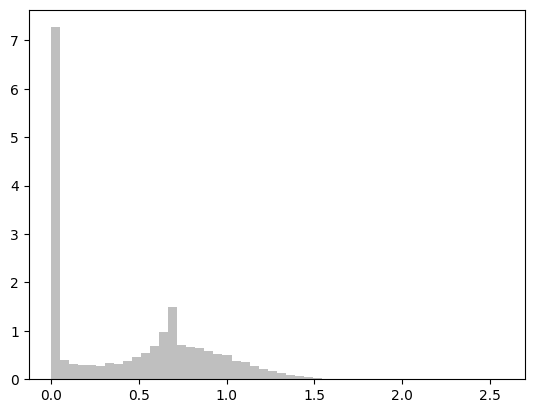

In [5]:
import matplotlib.pyplot as plt
# Plot the histogram of data
plt.hist(entropies, bins=50, density=True, alpha=0.5, color='gray', label='Data')

# # Plot each Gaussian component
# x = np.linspace(entropies.min(), entropies.max(), 1000).reshape(-1, 1)
# pdf_components = np.exp(gmm._estimate_weighted_log_prob(x))
# for i, pdf in enumerate(pdf_components.T):
#     plt.plot(x, pdf, label=f'Component {i+1}')

# # Plot overall GMM density
# pdf_gmm = np.exp(gmm.score_samples(x))
# plt.plot(x, pdf_gmm, label='GMM Fit', color='black', linewidth=2)

# plt.title('1D Gaussian Mixture Model')
# plt.xlabel('Data')
# plt.ylabel('Density')
# plt.legend()
plt.show()


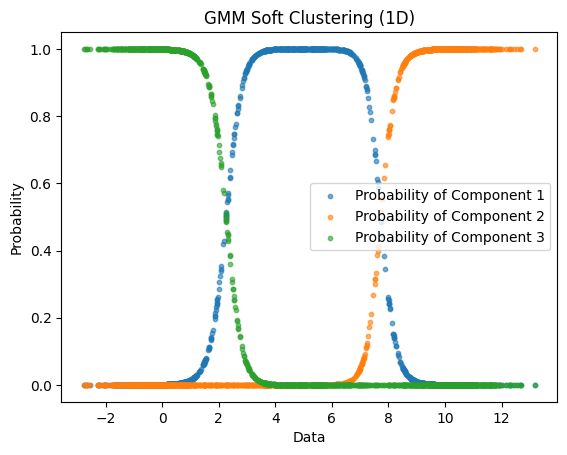

In [42]:
# Compute probabilities for each Gaussian
probs = gmm.predict_proba(data)

# Plot probabilities for each component
for i in range(gmm.n_components):
    plt.scatter(data, probs[:, i], label=f'Probability of Component {i+1}', alpha=0.6, s=10)

plt.title('GMM Soft Clustering (1D)')
plt.xlabel('Data')
plt.ylabel('Probability')
plt.legend()
plt.show()


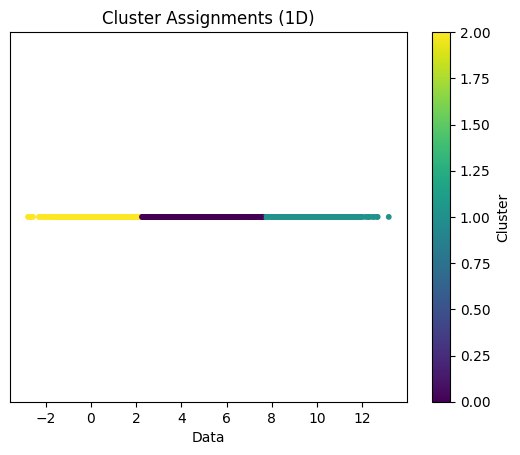

In [43]:
# Scatter plot with clusters
plt.scatter(data, np.zeros_like(data), c=clusters, cmap='viridis', s=10)
plt.title('Cluster Assignments (1D)')
plt.xlabel('Data')
plt.yticks([])
plt.colorbar(label='Cluster')
plt.show()
